In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import gc

from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow import keras

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
#Get all classes 
main_data_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/'
all_classes_names = os.listdir(main_data_dir)

/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/ride_bike/training_56.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/dive/training_70.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/stand/training_97.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/catch/testing_20.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/ride_horse/training_18.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/eat/testing_9.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/pour/training_56.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/sword_exercise/training_10.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/situp/training_17.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/cartwheel/testing_16.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/somersault/training_4.avi
/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/talk/testing_13.avi
/kaggle/inpu

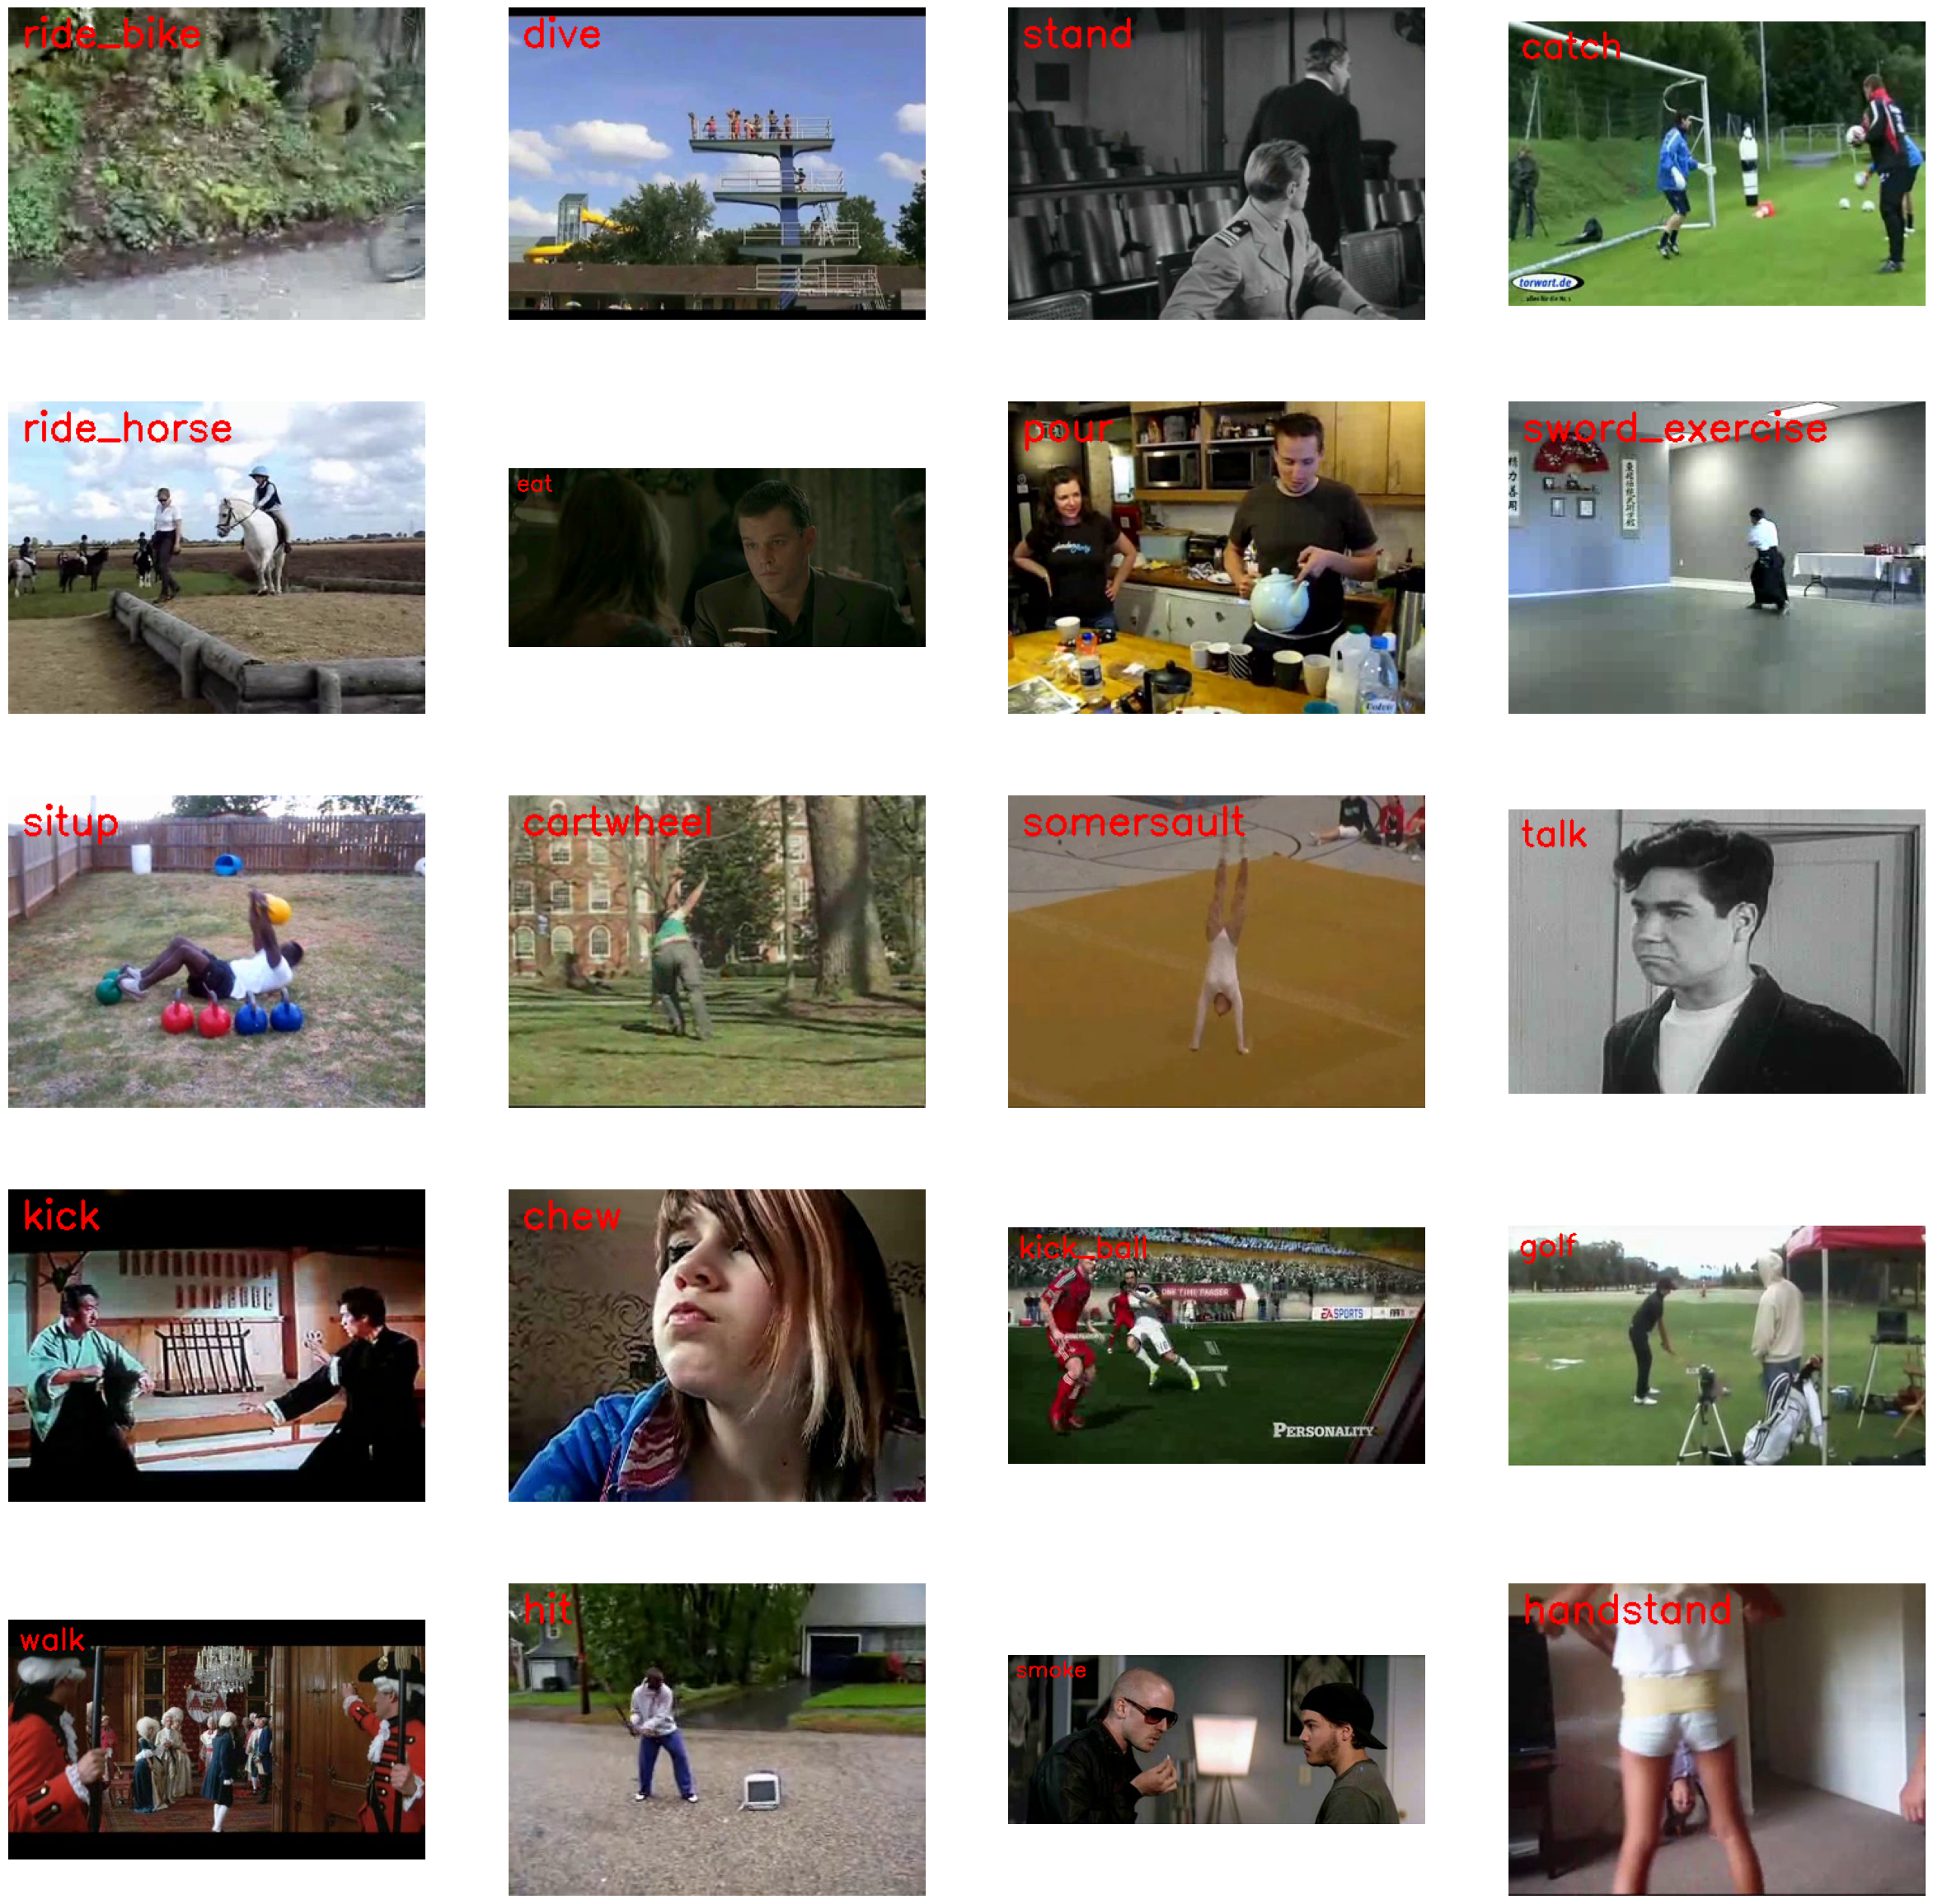

In [4]:
# Create a Matplotlib figure
fig = plt.figure(figsize = (30, 30))

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{main_data_dir}{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    print(f'{main_data_dir}{selected_class_Name}/{selected_video_file_name}')
    video_reader = cv2.VideoCapture(f'{main_data_dir}{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off') 


In [5]:
#Free RAM space
plt.close(fig)
fig.clf()
gc.collect()

40154

In [6]:
all_classes_names

['kick_ball',
 'catch',
 'shoot_ball',
 'climb_stairs',
 'punch',
 'stand',
 'smoke',
 'clap',
 'somersault',
 'drink',
 'pushup',
 'push',
 'talk',
 'fencing',
 'golf',
 'shake_hands',
 'sword',
 'kick',
 'dive',
 'eat',
 'kiss',
 'climb',
 'cartwheel',
 'pullup',
 'sword_exercise',
 'laugh',
 'jump',
 'pour',
 'chew',
 'walk',
 'shoot_gun',
 'dribble',
 'smile',
 'situp',
 'sit',
 'fall_floor',
 'hug',
 'ride_horse',
 'swing_baseball',
 'flic_flac',
 'run',
 'pick',
 'throw',
 'wave',
 'draw_sword',
 'turn',
 'brush_hair',
 'hit',
 'handstand',
 'ride_bike',
 'shoot_bow']

In [7]:
image_height, image_width = 64, 64
max_images_per_train_class = 8000
max_images_per_test_class = 4000
 
classes_list = ["shoot_gun", "shoot_ball", "kiss", "smoke"]
 
model_output_size = len(classes_list)
num_classes = 51

In [8]:
# Function to extract frames from a video
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

# Function to load data for selected classes
def create_dataset(main_data_dir, classes_list, max_images_per_class):
    data, labels = [], []
    for class_index, class_name in enumerate(classes_list):
        class_folder = os.path.join(main_data_dir, class_name)
        video_files = os.listdir(class_folder)

        count = 0
        for video_file in video_files:
            if count >= max_images_per_class:
                break

            video_path = os.path.join(class_folder, video_file)
            frames = frames_extraction(video_path)

            if frames:  # Ensure frames were extracted
                data.append(frames[0])  # Use the first frame (can use others too)
                labels.append(class_index)
                count += 1

    return np.array(data), np.array(labels)

# Create the dataset
max_images_per_class = 8000
X, y = create_dataset(main_data_dir, classes_list, max_images_per_class)
print(f"Dataset size: {X.shape}, Labels size: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_constant)

Dataset size: (445, 64, 64, 3), Labels size: (445,)


In [9]:
# Define the VGG16 base model with an explicit input shape
base = tf.keras.applications.VGG16(
    include_top=False,  # Remove the fully connected layers
    weights='imagenet',  # Use pretrained weights
    input_shape=(image_height, image_width, 3)  # Explicitly define the input shape
)

base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Build Model 
num_classes = 51
model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

# **Explicitly Build the Model by Passing Sample Input**
# Generate a sample input with the correct shape
sample_input = np.random.random((1, image_height, image_width, 3))  # Batch of 1
model(sample_input)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (1, 2, 2, 512)         │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 51)                │         3,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,988,531 (57.18 MB)

 Trainable params: 14,988,531 (57.18 MB)

 Non-trainable params: 0 (0.00 B)